In [1]:
import random
import sympy as sp
import json
import numpy as np
import cupy as cp 
import matplotlib.pyplot as plt

import multiprocessing
import time as t
import warnings

### First approach with recursively generated trees

In [2]:
# Liste des opérateurs binaires et des fonctions unaires.
OPERATORS = ['+', '-', '*', '/']
FUNCTIONS = ['sin', 'cos', 'exp', 'sqrt']

# Générateur récursif d'expressions mathématiques
def generate_expression(depth=3):
    if depth == 0:
        # Cas de base : on retourne à équiproba (à discuter) soit une variable, soit une constante
        return random.choice(['x', str(random.randint(1, 10))])
    
    # Choix d'une structure d'expression (opérateur binaire ou fonction unaire)
    expr_type = random.choice(['binary', 'unary'])
    
    if expr_type == 'binary':
        # Générer une expression binaire
        op = random.choice(OPERATORS)
        left = generate_expression(depth - 1)
        right = generate_expression(depth - 1)
        return f"({left} {op} {right})"
    
    elif expr_type == 'unary':
        # Générer une expression unaire
        func = random.choice(FUNCTIONS)
        inner_expr = generate_expression(depth - 1)
        return f"{func}({inner_expr})"

#this method would tend to favour deep over broad (Lample 2019). Can find a bias over depths distibution ?

In [6]:
# Exemple de génération
expression = generate_expression(depth=3)
print("Expression générée :", expression)

# Optionnel : convertir l'expression en une expression sympy
sympy_expr = sp.sympify(expression)
print("Expression sous forme SymPy :", sympy_expr)

Expression générée : (((x + x) + sin(x)) + ((x * 7) / cos(10)))
Expression sous forme SymPy : 7*x/cos(10) + 2*x + sin(x)


In [7]:
def evaluate_expression(expr, num_points=10, x_range=(-10, 10)):
    x = sp.symbols('x')
    sympy_expr = sp.sympify(expr)
    points = []
    for _ in range(num_points):
        x_val = random.uniform(*x_range)
        try:
            y_val = float(sympy_expr.subs(x, x_val))
            points.append((x_val, y_val))
        except (ZeroDivisionError, ValueError, TypeError): #added Type
            continue  # Ignorer les erreurs mathématiques
    return points

# Génération et stockage de plusieurs expressions avec leurs points d'échantillonnage
def generate_dataset(num_expressions=100, depth=3, num_points=10, x_range=(-10, 10)):
    dataset = []
    for _ in range(num_expressions):
        expr = generate_expression(depth)
        points = evaluate_expression(expr, num_points, x_range)
        dataset.append({
            'expression': expr,
            'points': points
        })
    return dataset

# Sauvegarder le dataset dans un fichier JSON
def save_dataset_to_json(dataset, filename="dataset.json"):
    with open(filename, 'w') as f:
        json.dump(dataset, f, indent=4)

In [8]:
# Exemple d'utilisation
dataset = generate_dataset(num_expressions=10, depth=3, num_points=10, x_range=(-10, 10))
save_dataset_to_json(dataset)
print("Dataset généré et sauvegardé dans dataset.json")

Dataset généré et sauvegardé dans dataset.json


### Method as in Kamienny 2022

In [2]:
def add_children(lis, place):
    lis.insert(place+1, None)
    lis.insert(place+2, None)

#distribution D(e, n) as in article where n_max = D_max (10) + b_max (5)
def distrib_binary_tree(n_max=15):
    distrib = np.zeros((n_max+2,n_max+1))
    distrib[0][1:] = 0
    distrib[1:,0] = 1
    for sum in range(2,n_max+2):
        for j in range(1,sum):
            i = sum - j
            distrib[i][j] = distrib[i-1][j] + distrib[i+1][j-1]
    return distrib
    
def generate_binary_tree(n,bin_list):
    tree = [None]
    e = 1
    distrib = distrib_binary_tree(n)

    while n>0 :
        k = random.choices(range(e), weights=[distrib[e-i+1,n-1]/distrib[e,n] for i in range(e)])[0]
        i = 0
        count = k
        while count >=0 :
            if count==0 and tree[i] is None :
                tree[i] = bin_list.pop(0)
                add_children(tree, i)
                count -= 1
            elif tree[i] is None :
                tree[i] = 'Leaf'
                i += 1
                count -= 1
            else :
                i += 1
            
        e = e - k + 1
        n -= 1
    
    for i in range(len(tree)):
        if tree[i] is None :
            tree[i] = 'Leaf'
    return tree

In [3]:
D_MAX = 2 #max dimension of input
u_max = 10 #max number of unary
N_MAX = 100 #max number of input values
BINARY = ['+', '-', '*']
BINARY_WEIGHTS = [1, 1, 1]
UNARY = ['inv','abs', 'sqr','sqrt','sin', 'cos', 'tan','arctan','log', 'exp']
UNARY_WEIGHTS = [5,1,3,3,1,1,0.2,0.2,0.2,1]
PRECISION = 2 #number pf digits
VARIABLES = [f'x{i}' for i in range(D_MAX)]
SYMBOLS = list(sp.symbols(' '.join(VARIABLES)))

class Sqr(sp.Function):
    @classmethod
    def eval(cls, x):
        return x ** 2
    
class Inv(sp.Function):
    @classmethod
    def eval(cls, x):
        return 1 / x
    
class Abs(sp.Function):
    @classmethod
    def eval(cls, x):
        return sp.Abs(x)

class Atan(sp.Function):
    @classmethod
    def eval(cls, x):
        return sp.atan(x)

symbol_dict = {str(var): var for var in SYMBOLS}
symbol_dict['inv'] = Inv
symbol_dict['sqr'] = Sqr
symbol_dict['abs'] = Abs
symbol_dict['arctan'] = Atan

In [4]:
def insert_multi(position, list1, list2):
    return list1[:position] + list2 + list1[position:]

def generate_integer(precision=2, max_exp=1):
    sign = random.choice([-1,1])
    mantissa = random.randint(1,10**precision)
    min_power = -max_exp - (precision + 1) // 2
    max_power = max_exp - (precision + 1) // 2   # ??
    exponent = random.randint(min_power, max_power+1)
    return round(sign * mantissa * 10**exponent, precision)

#generation as in article
def generate_expression_2() :
    D = random.randint(1, D_MAX)
    #D = 1
    variables = VARIABLES[:D]
    b_max = 5 + D #max number of binary
    b = random.randint(D-1, D+b_max)
    binary = random.choices(BINARY, weights=BINARY_WEIGHTS, k=b)

    expr = generate_binary_tree(b,binary)
    #print(expr)

    u = random.randint(0, u_max)
    # print(u)
    unary = random.choices(UNARY, weights=UNARY_WEIGHTS, k=u)
    while len(unary) > 0 :
        i = random.randint(0, len(expr)-1)
        una = unary.pop(0)
        expr = insert_multi(i, expr, [una])

    ession = []
    i = 0
    for x in expr :
        if x == 'Leaf' :
            x = random.choice(variables)
            m, p = generate_integer(PRECISION, max_exp=0), generate_integer(PRECISION,max_exp=0)
            ession += ['+',p,'*',m,x]
        elif x in UNARY :
            m, p = generate_integer(PRECISION, max_exp=0), generate_integer(PRECISION,max_exp=0)
            ession += ['+',p,'*',m, x]
        else :
            ession.append(x)
        i += 1
        
    return ession, D

In [5]:
def pref_to_inf(expr):
    stack = []
    for i in range(len(expr)-1,-1,-1):
        e = expr[i]
        if e in BINARY:
            right = stack.pop()
            left = stack.pop()
            stack.append(f"({left} {e} {right})")
        elif e in UNARY:
            right = stack.pop()
            stack.append(f"{e}({right})")
        else :
            stack.append(str(e))
    return stack[0]

In [6]:
def simplify(expr, variables):
    infixed_expr = pref_to_inf(expr)
    sympy_expr = sp.sympify(infixed_expr, locals=symbol_dict)
    return sp.simplify(sympy_expr)

In [152]:
(expr, D) = generate_expression_2()
print(pre_expr)
print(expr)
#simplify(expr, SYMBOLS)

# Start the process
process = multiprocessing.Process(target=simplify, args=(expr, SYMBOLS))
process.start()

# Wait for 3 seconds and terminate
t.sleep(30)
process.terminate()  # Kill the process
process.join()  # Ensure the process has finished
print("Process terminated")

# tentative for graceful stopping (non applicable here)
#NOTE : here running on Windows so cant use signal :/

# Flag to signal the thread
#stop_event = threading.Event()
#
#def slow_function():
#    while not stop_event.is_set():
#        print("Working...")
#        t.sleep(1)  # Simulate work
#    print("Thread stopping...")
#
## Start the thread
#thread = threading.Thread(target=slow_function)
#thread.start()
#
## Wait and signal the thread to stop after 3 seconds
#t.sleep(3)
#stop_event.set()  # Signal the thread to stop
#thread.join()  # Wait for the thread to finish
#print("Thread terminated gracefully")

['+', 'log', '*', 'Leaf', '+', 'sqrt', 'Leaf', 'sqr', 'Leaf', 'tan', 'Leaf']
['+', '+', -6.3, '*', -9.8, 'log', '*', '+', 79, '*', -51, 'x0', '+', '+', -3.2, '*', -5.9, 'sqrt', '+', 4.0, '*', -75, 'x1', '+', -45, '*', 2.0, 'sqr', '+', -7.3, '*', -2.8, 'x1', '+', -2.8, '*', 33, 'tan', '+', 5.3, '*', 67, 'x0']
Process terminated


#### Sample datapoints

In [7]:
K_MAX = 10 #max number of clusters

def haar_random_matrix(n):
    Z = np.random.randn(n, n)
    Q, R = np.linalg.qr(Z)
    if np.linalg.det(Q) < 0:
        Q[:, 0] = -Q[:, 0]
    return Q
     

def generate_input_point(D):  #argument=dimension of input.
    N = random.randint(10*D, N_MAX)
    k = random.randint(1, K_MAX)
    w = np.random.uniform(0, 1, k)
    w = w / np.sum(w)
    x = np.zeros((0,D)) 
    #print(N,k)
    for i in range(k):
        mu = np.random.uniform(0, 1, D)
        sigma = np.random.uniform(0, 1, D)
        distrib = np.random.choice(['normal', 'uniform'])
        if distrib == 'normal':
            number_points = int(np.floor(N * w[i]))
            haar_rotation = haar_random_matrix(number_points)
            sampled_points = np.random.normal(mu, sigma, (number_points,D))
            new_points = np.matmul(haar_rotation, sampled_points)
            x = np.vstack((x, new_points))
        else:
            lower_bound = mu - np.sqrt(3) * sigma
            upper_bound = mu + np.sqrt(3) * sigma
            number_points = int(np.floor(N * w[i]))
            haar_rotation = haar_random_matrix(number_points)
            sampled_points = np.random.uniform(lower_bound, upper_bound, (number_points,D))
            new_points = np.matmul(haar_rotation, sampled_points)
            x = np.vstack((x, new_points))
    normalized_x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    return normalized_x

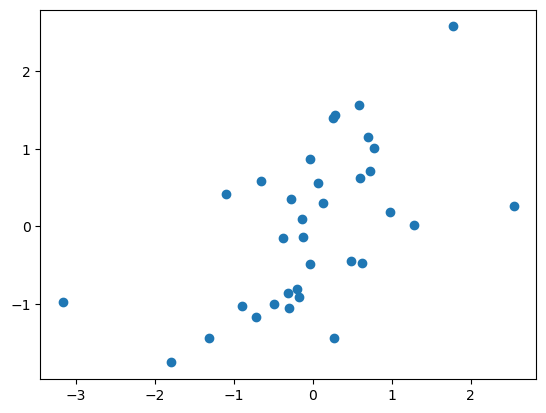

In [11]:
x = generate_input_point(2)
plt.figure()

plt.scatter(x[:,0], x[:,1])
plt.show()

### Évaluation

In [8]:
#CPU version ; see <https://docs.sympy.org/latest/modules/numeric-computation.html>

def evaluation2():
    expr,D = generate_expression_2()
    #sympy_expr= simplify(expr, SYMBOLS) #can implement conditional simplification here
    sympy_expr = sp.sympify(pref_to_inf(expr), locals=symbol_dict)
    func = sp.lambdify((SYMBOLS[:D],), sympy_expr, "numpy")

    x = generate_input_point(D)
    with warnings.catch_warnings():
        warnings.simplefilter("error", RuntimeWarning)  # Treat RuntimeWarnings as errors
        try:
            y = func(x.T)
            return expr, x, y
        except RuntimeWarning as rw:
            raise ValueError(f"RuntimeWarning encountered : {rw}")

In [9]:
#GPU version for big tensors : see <https://docs.sympy.org/latest/modules/numeric-computation.html>
#should also try aesara, which seems to perform simplification also.

def evaluation2_gpu():
    expr,D = generate_expression_2()
    #sympy_expr= simplify(expr, SYMBOLS) #can implement conditional simplification here
    sympy_expr = sp.sympify(pref_to_inf(expr), locals=symbol_dict)
    func = sp.lambdify((SYMBOLS[:D],), sympy_expr, "cupy")

    x = cp.asarray(generate_input_point(D))
    y = func(x.T)
    sum = cp.dot(y, y)
    if not cp.isnan(sum) and not cp.isinf(sum):
        return expr, x, y
    else:
        raise ValueError(f"RuntimeWarning encountered")

### Building a dataset

In [10]:
# Génération et stockage de plusieurs expressions avec leurs points d'échantillonnage
def generate_dataset2(num_expressions=100):
    dataset = []
    i=0
    while i < num_expressions :
        try :
            expr, x, y = evaluation2()
            dataset.append({
            'expression': expr,
            'points': x,
            'values':y
        })
            #i+=1
        except ValueError :
            pass
            i+=1
    return dataset

In [11]:
# Génération et stockage de plusieurs expressions avec leurs points d'échantillonnage
def generate_dataset2_gpu(num_expressions=100):
    dataset = []
    i=0
    while i < num_expressions :
        try :
            expr, x, y = evaluation2_gpu()
            dataset.append({
            'expression': expr,
            'points': x,
            'values':y
        })
            i+=1
        except (ValueError, OverflowError) :
            pass
    return dataset

In [482]:
SIZE = 500

D_MAX = 2 #max dimension of input
u_max = 10 #max number of unary
N_MAX = 100 #max number of input values
BINARY = ['+', '-', '*']
BINARY_WEIGHTS = [1, 1, 1]
UNARY = ['inv','abs', 'sqr','sqrt','sin', 'cos', 'tan','arctan','log', 'exp']
UNARY_WEIGHTS = [5,1,3,3,1,1,0.2,0.2,0.2,1]
PRECISION = 2 #number pf digits
VARIABLES = [f'x{i}' for i in range(D_MAX)]
SYMBOLS = list(sp.symbols(' '.join(VARIABLES)))
GPU=False

# Exemple d'utilisation
for i in range(0, 6) :
    t1 = t.time()
    if not GPU :
        dataset = generate_dataset2(num_expressions=SIZE)
        np.save(f'D{D_MAX}_u{u_max}_N{N_MAX}_{i}.npy', dataset)
    else :
        dataset = generate_dataset2_gpu(num_expressions=SIZE)
        cp.save(f'D{D_MAX}_u{u_max}_N{N_MAX}_{i}_gpu.npy', dataset)
    t2 = t.time()
    print(f"Dataset généré et sauvegardé dans dataset{i}.npy", t2-t1)

Dataset généré et sauvegardé dans dataset0.npy 50.77748131752014
Dataset généré et sauvegardé dans dataset1.npy 50.836076498031616
Dataset généré et sauvegardé dans dataset2.npy 52.23013186454773


KeyboardInterrupt: 

In [20]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

# Function to evaluate one random expression
def evaluation3(_=None):
    # 1. Generate a random expression
    expr,D = generate_expression_2()
    sympy_expr = sp.sympify(pref_to_inf(expr), locals=symbol_dict)

    # 2. Lambdify the expression with NumPy backend
    func = sp.lambdify((SYMBOLS[:D],), sympy_expr, "numpy")

    # 3. Generate random input data
    x = generate_input_point(D)

    # 4. Evaluate the function
    with warnings.catch_warnings():
        warnings.simplefilter("error", RuntimeWarning)  # Treat RuntimeWarnings as errors
        try:
            y = func(x.T)
            return {
            'expression': expr,
            'points': x,
            'values':y
        }
        except RuntimeWarning as rw:
            pass
            #raise ValueError(f"RuntimeWarning encountered : {rw}")

# Function to parallelize multiple evaluations
def parallel_evaluation(num_expressions=100):
    results = []
    with ThreadPoolExecutor() as executor:
        # Submit tasks to generate and evaluate random expressions
        futures = [executor.submit(evaluation3) for _ in range(num_expressions)]
        for future in futures:
            results.append(future.result())
    return results

def parallel_evaluation3(num_expressions=100):
    results = []
    with ProcessPoolExecutor() as executor:
        # Submit tasks to generate and evaluate random expressions
        futures = [executor.submit(evaluation3) for _ in range(num_expressions)]
        for future in futures:
            results.append(future.result())
    return results

from multiprocessing import Pool

def parallel_evaluation2(num_expressions=100):
     async_results = []
     with Pool() as pool:
         for _ in range(num_expressions):
             async_results.append(pool.apply_async(evaluation3))
         pool.close()
         pool.join()
     results = []
     for async_result in async_results:
         results.append(async_result.get())
     return results

In [27]:
SIZE = 500

D_MAX = 2 #max dimension of input
u_max = 10 #max number of unary
N_MAX = 100 #max number of input values
BINARY = ['+', '-', '*']
BINARY_WEIGHTS = [1, 1, 1]
UNARY = ['inv','abs', 'sqr','sqrt','sin', 'cos', 'tan','arctan','log', 'exp']
UNARY_WEIGHTS = [5,1,3,3,1,1,0.2,0.2,0.2,1]
PRECISION = 2 #number pf digits
VARIABLES = [f'x{i}' for i in range(D_MAX)]
SYMBOLS = list(sp.symbols(' '.join(VARIABLES)))
GPU=False

for i in range(0, 1) :
    t1 = t.time()
    if __name__ == '__main__':
        dataset = parallel_evaluation(num_expressions=SIZE)
    np.save(f'D{D_MAX}_u{u_max}_N{N_MAX}_{i}_parallel.npy', dataset)
    t2 = t.time()
    print(f"Dataset généré et sauvegardé dans dataset{i}.npy", t2-t1)

Dataset généré et sauvegardé dans dataset0.npy 28.36929678916931


In [484]:
np.load('D2_u10_N100_0_parallel.npy', allow_pickle=True)

array([{'expression': ['+', '+', -4.3, '*', 5.2, 'abs', '+', -44, '*', -95, 'x0', '+', '+', -7.4, '*', -89, 'x0', '+', '+', 64, '*', -2.4, 'x0', '+', '-', '+', -53, '*', 1.5, 'abs', '+', -6.1, '*', -9.3, 'sqr', '+', -94, '*', -6.0, 'x0', '+', 77, '*', -9.2, 'x0', '+', 99, '*', 100, 'x0'], 'points': array([[-0.68162073],
              [ 0.29641728],
              [-0.08590601],
              [-0.55063417],
              [-0.37793566],
              [-0.96123535],
              [ 0.92424678],
              [ 0.51361273],
              [-1.60839547],
              [-0.43352203],
              [ 0.11842728],
              [-0.09922789],
              [-2.68985298],
              [ 0.45379014],
              [ 1.37322183],
              [ 0.09388853],
              [ 1.38711139],
              [-1.00314092],
              [-0.71776303],
              [ 0.36278114],
              [-1.08502403],
              [ 2.95210423],
              [ 0.53701938],
              [ 2.17456163],
           